In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import numpy as np
import re,unicodedata,nltk
from transformers import AutoTokenizer, TFXLMRobertaForSequenceClassification, BertConfig
import keras
import pickle

# gpus = tf.config.list_physical_devices("GPU")
# if gpus:
#     for gpu in gpus:
#         print("Found a GPU with the name:", gpu)
# else:
#     print("Failed to detect a GPU.")


In [3]:
with open('/content/drive/MyDrive/PECE/models/dataset_train_test/dataset_dict.pickle', 'rb') as file:
    dataset_dict = pickle.load(file)

num_classes = dataset_dict['n_class']

In [4]:
model_id = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = TFXLMRobertaForSequenceClassification.from_pretrained(model_id,num_labels=num_classes,num_hidden_layers =12,hidden_dropout_prob=0.4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForSequenceClassification: ['roberta.encoder.layer.12.attention.self.query.weight', 'roberta.encoder.layer.15.attention.self.key.bias', 'roberta.encoder.layer.12.attention.output.LayerNorm.weight', 'roberta.encoder.layer.16.output.LayerNorm.bias', 'roberta.encoder.layer.13.attention.output.LayerNorm.bias', 'roberta.encoder.layer.12.output.dense.weight', 'roberta.encoder.layer.17.attention.self.value.bias', 'roberta.encoder.layer.14.attention.self.value.weight', 'roberta.encoder.layer.20.attention.self.query.bias', 'roberta.encoder.layer.14.attention.output.dense.bias', 'roberta.encoder.layer.21.attention.self.key.weight', 'roberta.encoder.layer.18.output.dense.weight', 'roberta.encoder.layer.15.attention.output.LayerNorm.bias', 'roberta.encoder.layer.23.attention.self.key.weight', 'roberta.encoder.layer.23.attention.self.key.bias', 'roberta.encoder.layer.18.attention.self.key.weight', 'robert

In [5]:

def applytokenizer(sentences):
  input_ids=[]
  attention_masks=[]

  for sent in sentences:
      bert_inp=tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 64, padding='max_length',return_attention_mask = True)
      input_ids.append(bert_inp['input_ids'])
      attention_masks.append(bert_inp['attention_mask'])

  input_ids=np.asarray(input_ids)
  attention_masks=np.array(attention_masks)
  return [input_ids,attention_masks]

In [6]:
X_train = applytokenizer(dataset_dict['X_train'])
X_test = applytokenizer(dataset_dict['X_test'])
y_train = np.asarray(dataset_dict['y_train'])
y_test = np.asarray(dataset_dict['y_test'])

In [7]:
log_dir='/content/drive/MyDrive/PECE/tensorboard_data/tb_xlmroberta_v5'
model_save_path='/content/drive/MyDrive/PECE/models/xlmroberta_model_v5.h5'

callbacks = [
             keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),
             keras.callbacks.TensorBoard(log_dir=log_dir),
            keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0.01,patience=50,verbose=0,mode="min")
             ]

print('\nXLM-RoBERTa Model',model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

Model: "tfxlm_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFXLMRobertaMainL  multiple                  407686144 
 ayer)                                                           
                                                                 
 classifier (TFXLMRobertaCl  multiple                  1067025   
 assificationHead)                                               
                                                                 
Total params: 408753169 (1.52 GB)
Trainable params: 408753169 (1.52 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

XLM-RoBERTa Model None


In [8]:
history=model.fit(X_train,y_train,batch_size=32,epochs=600,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/600
9/9 [==============================] - 77s 4s/step - loss: 2.8653 - accuracy: 0.0607 - val_loss: 2.8118 - val_accuracy: 0.1000
Epoch 2/600
9/9 [==============================] - 11s 1s/step - loss: 2.8027 - accuracy: 0.0821 - val_loss: 2.7603 - val_accuracy: 0.1143
Epoch 3/600
9/9 [==============================] - 12s 1s/step - loss: 2.7639 - accuracy: 0.0964 - val_loss: 2.7266 - val_accuracy: 0.1000
Epoch 4/600
9/9 [==============================] - 12s 1s/step - loss: 2.7421 - accuracy: 0.0893 - val_loss: 2.7103 - val_accuracy: 0.1000
Epoch 5/600
9/9 [==============================] - 12s 1s/step - loss: 2.7097 - accuracy: 0.1214 - val_loss: 2.7062 - val_accuracy: 0.1000
Epoch 6/600
9/9 [==============================] - 11s 1s/step - loss: 2.7232 - accuracy: 0.1000 - val_loss: 2.7047 - val_accuracy: 0.1000
Epoch 7/600
9/9 [==============================] - 12s 1s/step - loss: 2.7401 - accuracy: 0.0857 - val_loss: 2.7018 - val_accuracy: 0.1000
Epoch 8/600
9/9 [==========

In [9]:
with open('/content/drive/MyDrive/PECE/models/xlmroberta_model_v5', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
model.config.to_json_file('/content/drive/MyDrive/PECE/models/Config-XLM-RoBERTa-fine-tuning_v5.json')

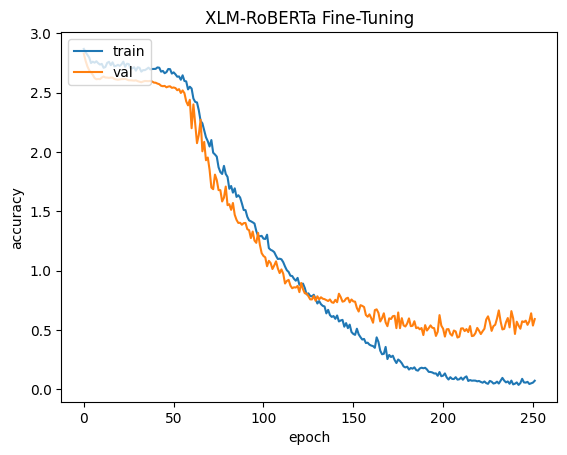

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('XLM-RoBERTa Fine-Tuning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.savefig('/content/drive/MyDrive/PECE/models/XLM-RoBERTa-fine-tuning_v5.png')
model.config.to_json_file('/content/drive/MyDrive/PECE/models/Config-XLM-RoBERTa-fine-tuning_v5.json')

<Figure size 640x480 with 0 Axes>

In [ ]:



import json

# Convert and write JSON object to file
with open("/content/drive/MyDrive/PECE/resoucers/dict_classes.json", "w") as outfile:
    json.dump(dict_classes, outfile)



In [ ]:
dict_classes = dict([i for i in zip(data['gt'].astype(str).values,data['label'].values)])
labels_dict = [dict_classes[str(i)] for i in [*range(len(list(dict_classes.keys())))]]

In [ ]:
model_id = 'neuralmind/bert-base-portuguese-cased'
model_save_path='/content/drive/MyDrive/PECE/models/bertimbau_model.h5'

tokenizer = AutoTokenizer.from_pretrained(model_id)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

trained_model = TFBertForSequenceClassification.from_pretrained(model_id,num_labels=num_classes)
# trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

preds = trained_model.predict([val_inp,val_mask],batch_size=1)
pred_labels = np.argmax(preds.logits, axis=1)
f1 = f1_score(val_label,pred_labels,average='micro')
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels,target_names=labels_dict))

print('Training and saving built model.....')

#FOCO NO RECALL > 80%
#APOS ISSO PRECISAO

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


55/55 [==============================] - 4s 8ms/step
F1 score 0.9090909090909091
Classification Report
                                     precision    recall  f1-score   support

               CARGO_DO_FUNCIONARIO       1.00      1.00      1.00         5
        DEPARTAMENTO_DO_FUNCIONARIO       1.00      1.00      1.00         4
           INFORMACAO_SOBRE_CLIENTE       1.00      0.75      0.86         4
                  LOCALIZAR_CLIENTE       0.67      1.00      0.80         2
              LOCALIZAR_FUNCIONARIO       1.00      1.00      1.00         4
   LOCALIZAR_PRODUTOS_PELA_PRODUCAO       0.75      1.00      0.86         3
      LOCALIZAR_PRODUTOS_PELO_CUSTO       0.86      1.00      0.92         6
      METRICAS_DE_CUSTO_DE_PRODUTOS       0.50      1.00      0.67         1
   METRICAS_DE_PRODUCAO_DE_PRODUTOS       1.00      1.00      1.00         5
 METRICAS_DE_PRODUTOS_POR_CATEGORIA       1.00      0.25      0.40         4
              METRICAS_DOS_CLIENTES       0.86   

In [ ]:
teste = "Quantos funcionarios tem no setor de marketing?"

In [ ]:
input_ids=[]
attention_masks=[]

bert_inp=tokenizer.encode_plus(teste,add_special_tokens = True,max_length =64, pad_to_max_length = True,return_attention_mask = True)
input_ids.append(bert_inp['input_ids'])
attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:

preds = trained_model.predict([input_ids,attention_masks],batch_size=1)


1/1 [==============================] - 0s 26ms/step


In [ ]:
teste=np.where(preds.logits>=0.50,1,0)

In [ ]:
preds.logits

array([[-1.7778617 , -0.53754526, -0.90348244, -0.8599582 ,  1.6856688 ,
        -0.44356814, -0.70820117, -1.3051971 , -0.49319133, -0.8795275 ,
         0.80512565,  5.828703  , -0.9201504 ,  2.0146732 , -0.72137386]],
      dtype=float32)

In [ ]:
for i,col in enumerate(teste[0]):
  if col == 1:
    print(dict_classes[i],preds.logits[0][i])

KeyError: 4

In [ ]:
pred_labels = np.argmax(preds.logits, axis=1)

In [ ]:
pred_labels

array([11])

In [ ]:
guia = data.label.unique()

In [ ]:
dict_classes[str(pred_labels[0])]

'METRICAS_DO_QUADRO_DE_FUNCIONARIOS'